# Import Library

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import usrLibrary as lib
from matplotlib import rc

# Class Condition

## Optical Condition

In [2]:
class optical_condition:
    L:      float # distance from the sample plane to the detector plane
    p:      float # pixel size of the detector
    Npixel: int   # window size of the probe function, object functions, and diffraction patterns
    energy: float # x-ray energy of the incident beam
    h:      float # plank constant
    c:      float # velocity of the light
    lamb:   float # wavelength
    k:      float # wavenumber
    dx:     float # pixel resolution at the sample plane
    DR:     float # dynamic range of the detector, for example opt.DR = log10{1e7 (photons) / 1 (photon}
    Wnoise: bool  # flag to apply photon shot noise to each calculated diffraction pattern

In [3]:
opt         = optical_condition()

opt.L       = 3                                         # unit: m
opt.p       = 75e-6                                     # unit: m
opt.Npixel  = 1024                                      # unit: pixel
opt.energy  = 5000                                      # unit: eV (electronVolt)
opt.h       = 6.62607015e-34                            # unit: m^2 kg/s
opt.c       = 299792458                                 # unit: m/s
opt.lamb    = (opt.h * 6.242e18) * opt.c / opt.energy   # unit: m
opt.k       = 2 * np.pi / opt.lamb                      # unit: 1/m
opt.dx      = opt.L * opt.lamb / (opt.Npixel * opt.p)   # unit: m/pixel
opt.DR      = 7
opt.Wnoise  = True


## Aperture Condition

In [4]:
class aperture_condition:
    sideNumber:         int     # number of the side
    sideLength:         float   # length of a side
    Lpropagation:       float   # distance from the aperture to the sample
    needPropagation:    bool    # flag whether propagation from the aperture to the sample is needed

In [1]:
aper = aperture_condition()

aper.sideNumber     = 3     # input: 3 --> Triangle
aper.sideLength     = 5e-6  # unit: m
aper.Lpropagation   = 0     # unit: m, range: # 500-1000*10^-6

if aper.Lpropagation > 0:
    aper.needPropagation = True
else:
    aper.needPropagation = False

NameError: name 'aperture_condition' is not defined

## Particle Condition

In [16]:
class particle_condition:
    beta_Au:    float # parameter related to the absorption of the wavefield
    delta_Au:   float # parameter related to the phase shift of the wavefield
    diameter:   float # diameter of the gold nanoparticle
    ratio:      float # (Area occupied with gold nanoparticles) / (Area of the window, Npixel x Npixel)
    number:     int   # total number of the gold nanoparticles within the window
    velocity:   float # displacement of the gold nanoparticles (per frame)

In [17]:
par = particle_condition()

par.beta_Au     = 2.633e-5
par.delta_Au    = 1.2143e-4
par.diameter    = 150e-9 #300e-9 # unit: m
par.ratio       = 100e-3
par.number      = int(np.floor((opt.Npixel * opt.dx)**2 / (np.pi * (par.diameter / 2)**2) * par.ratio))
par.Nframe      = 2
par.velocity    = 10 * opt.dx    # unit: m/frame

**Note**:

datebase to get the parameters about the beta and delta for differenct material or X-ray energy...
https://henke.lbl.gov/optical_constants/pert_form.html

# Calculation of the object functions, probe function and diffraction patterns

In [18]:
# set different seed per 5 frame
np.random.seed(1)

## Probe Function, Npixel x Npixel

In [19]:
aperture = lib.calcAperture(opt, aper)

if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(aperture, opt, aper)
else:
    inwave = aperture

## Object Function, Npixel x Npixel x Nframe

In [20]:
# AuNPimg = lib.calcAuNP(opt, par) * mask_new[:,:,np.newaxis]
AuNPimg = lib.calcAuNP(opt, par)

0
1


## Calculate Wavefield at the Detectir Plane, Size: Npixel x Npixel x Nframe

In [21]:
wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

## Calculate Diffraction Pattern, size: Npixel x Npixel x Nframe

In [22]:
difImg       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise = np.random.poisson(difImg)

# Show Aperture

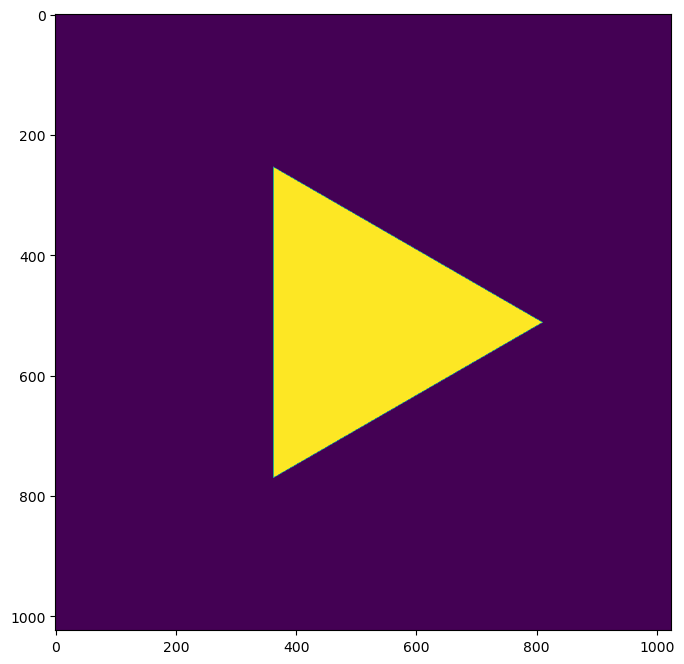

In [23]:
fig = plt.figure(figsize = [8, 8])
plt.imshow(inwave)

# Animation for All Generated Frame

In [25]:
matplotlib.rcParams['animation.embed_limit'] = 10e4

fig = plt.figure(figsize = [8, 8])
artists = []

for iFrame in range(par.Nframe):
    im = plt.imshow(np.abs(AuNPimg[:, :, iFrame])*inwave)
    artists.append([im])

animate = animation.ArtistAnimation(fig, artists)
plt.colorbar()
rc("animation", html = "jshtml")
plt.close()
animate

# Diffraction Image Wnoise

In [26]:
fig = plt.figure(figsize = [5, 5])
artists = []

for iFrame in range(par.Nframe):
    im = plt.imshow(np.log10(difImgWnoise[:, :, iFrame] + 1e-5))
    artists.append([im])

animate = animation.ArtistAnimation(fig, artists)
rc("animation", html = "jshtml")
plt.close()
animate